In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

EN = 16 #embedding size
CH = 3 #number of channels

ImageW = 1000
ImageH = 1000

def Sample(tex, i, j, k):
    #return tex[i, j, k]
    res = tf.clamp(tf.round(127.0*tex[i, j, k]).pass_grad(), -127.0, 127.0)
    return res / 127.0

def Bilinear(tex, x, y, ch):
    #offset each channel to avoid discontinuities
    chidx = ch/4
    offset_x = tf.float(chidx%2) / 2.0
    offset_y = tf.float(chidx/2) / 2.0
    x, y = x+offset_x, y+offset_y
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)

    #fake cubic interpolation
    xf = tf.smoothstep(0.0, 1.0, xf)
    yf = tf.smoothstep(0.0, 1.0, yf)

    oxf, oyf = 1.0-xf, 1.0-yf
    #return tex[xi, yi, ch]*oxf*oyf + tex[xi+1, yi, ch]*xf*oyf + tex[xi, yi+1, ch]*oxf*yf + tex[xi+1, yi+1, ch]*xf*yf
    return Sample(tex, xi, yi, ch)*oxf*oyf + Sample(tex, xi+1, yi, ch)*xf*oyf + Sample(tex, xi, yi+1, ch)*oxf*yf + Sample(tex, xi+1, yi+1, ch)*xf*yf

def mul_bias(X, W):
    ids = tf.indices(list(X.shape[:-1]) + [W.shape[-2]])
    return tf.select(ids[-1] == X.shape[-1], 0.01, X[ids]) @ W

def GELU(x):
    return 0.5*x*(1.0+tf.tanh(0.7978845608*(x+0.044715*x*x*x)))

def Decode(tex, W1, W2, x, y):
    embed = Bilinear(tex, x, y, x.indices[-1])
    #small neural network
    embed = tf.sin(mul_bias(embed, W1))
    return (mul_bias(embed, W2))

def NeuralEmbed():
    tex = tf.input([-1, -1, EN], tf.float32)
    RN = tex.shape[0]
    pos = tf.input([-1, 2], tf.float32)
    N = pos.shape[0]
    vals = tf.input([N, CH], tf.float32)
    W1 = tf.input([EN+1, -1], tf.float32)
    HiddenSize = W1.shape[1]
    W2 = tf.input([HiddenSize+1, CH], tf.float32)

    params = tf.input([-1], tf.float32)
    tex_lr = params[0]
    weight_lr = params[1]

    i, j = tf.indices([N, EN])
    samp = Decode(tex, W1, W2, pos[i, 0], pos[i, 1])
    
    diff = samp-vals
    loss = tf.sum(tf.sum(diff*diff)) / tf.float(N)
    
    W1 -= weight_lr*tf.grad(loss, W1)
    W2 -= weight_lr*tf.grad(loss, W2)
    tex -= tex_lr*tf.grad(loss, tex)

    return tex, W1, W2, loss

reconstruct = tf.compile(NeuralEmbed)

def RenderImage():
    tex = tf.input([-1, -1, EN], tf.float32)
    RN = tex.shape[0]
    W1 = tf.input([EN+1, -1], tf.float32)
    HiddenSize = W1.shape[1]
    W2 = tf.input([HiddenSize+1, CH], tf.float32)

    i, j, e = tf.indices([ImageH, ImageW, EN])
    x, y = tf.float(i*(RN-1))/float(ImageH), tf.float(j*(RN-1))/float(ImageW)
    x = tf.float(RN-1) - x
    render = Decode(tex, W1, W2, x, y)
    return render

render = tf.compile(RenderImage)

TensorFrost module loaded!
NeuralEmbed:
  Kernel count: 18
  Intermediate buffers: 11
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 491
  IR Compile time: 58.354900 ms
  Compiler time: 1600.797729 ms

RenderImage:
  Kernel count: 2
  Intermediate buffers: 1
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 442
  IR Compile time: 9.341400 ms
  Compiler time: 1425.983521 ms



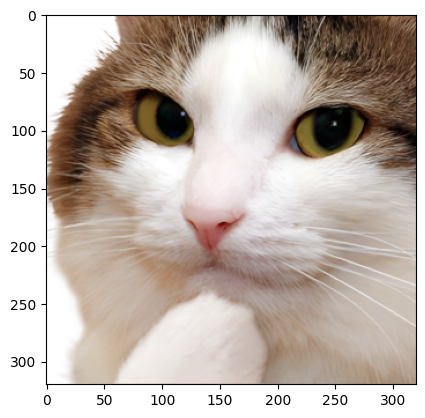

(320, 320, 4)


In [2]:
input_img = np.array(plt.imread("test.png"), dtype=np.float32)
plt.imshow(input_img)
plt.show()
print(input_img.shape)


input_img = input_img[:,:,:3] *input_img[:,:,3:4]

In [3]:
RN = 32

#get list of pixels
N = input_img.shape[0]*input_img.shape[1]
pos = np.zeros((N, 2))
vals = np.zeros((N, CH))
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        pos[i*input_img.shape[1]+j] = [i/input_img.shape[0], j/input_img.shape[1]]
        vals[i*input_img.shape[1]+j] = input_img[i, j]

pos *= (np.array([RN - 1, RN - 1]))

#randomize the order
order = np.arange(N)
np.random.shuffle(order)
pos = pos[order]
vals = vals[order]

In [4]:
hidden = EN #hidden layer size
embedd = EN #embedding size
embedding_tex = np.random.randn(RN, RN, embedd) / 30.0
tex_tf = tf.tensor(embedding_tex)
W1 = np.random.randn(embedd+1, hidden) / np.sqrt(hidden)
for i in range(embedd):
    W1[i, :] *= 40.0


In [5]:
W1_tf = tf.tensor(W1)
W2_tf = tf.tensor(np.random.randn(hidden+1, CH) / np.sqrt(CH))

In [6]:
tex_tf = tf.tensor(embedding_tex * 0.0)

In [7]:
import time

tf.show_window(ImageW, ImageH, "reconstruction")

prev_time = time.time()
smooth_delta_time = 0.0
do_optimization = False

lr = 0.05

batch_size = 256
iters_per_frame = 16
loss_hist = []
loss_val = 0.0
freeze_weights = False
freeze_tex = False

while not tf.window_should_close():
    cur_time = time.time()

    delta_time = cur_time - prev_time
    smooth_delta_time = 0.9 * smooth_delta_time + 0.1 * delta_time

    if do_optimization:
        params = np.array([0.0 if freeze_tex else lr, 0.0 if freeze_weights else lr])
        params_tf = tf.tensor(params)
        for _ in range(iters_per_frame):
            rand_offset = np.random.randint(N - batch_size)
            pos_tf = tf.tensor(pos[rand_offset:rand_offset+batch_size])
            vals_tf = tf.tensor(vals[rand_offset:rand_offset+batch_size])
            tex_tf, W1_tf, W2_tf, loss = reconstruct(tex_tf, pos_tf, vals_tf, W1_tf, W2_tf, params_tf)
        loss_val = loss.numpy
        loss_hist.append(loss_val)

    tf.render_frame(render(tex_tf, W1_tf, W2_tf))
    tf.imgui_text("Frame time: %.3f ms" % (1000.0 * smooth_delta_time))
    tf.imgui_text("FPS: %.1f" % (1.0 / (smooth_delta_time + 1e-5)))
    do_optimization = tf.imgui_checkbox("Optimize", do_optimization)
    tf.imgui_text("Loss: %.5f" % loss_val)
    lr = tf.imgui_slider("Learning rate", lr, 0.0, 1.0)
    iters_per_frame = tf.imgui_slider("Iterations per frame", iters_per_frame, 1, 100)
    batch_size = tf.imgui_slider("Batch size", batch_size, 64, 10000)
    freeze_weights = tf.imgui_checkbox("Freeze weights", freeze_weights)
    freeze_tex = tf.imgui_checkbox("Freeze texture", freeze_tex)
    
    prev_time = cur_time

print("Final loss: %.5f" % loss_val)

C:\Users\micha\AppData\Local\Temp\ipykernel_52052\704438509.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tf.imgui_text("Loss: %.5f" % loss_val)


Final loss: 0.00354


C:\Users\micha\AppData\Local\Temp\ipykernel_52052\704438509.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Final loss: %.5f" % loss_val)


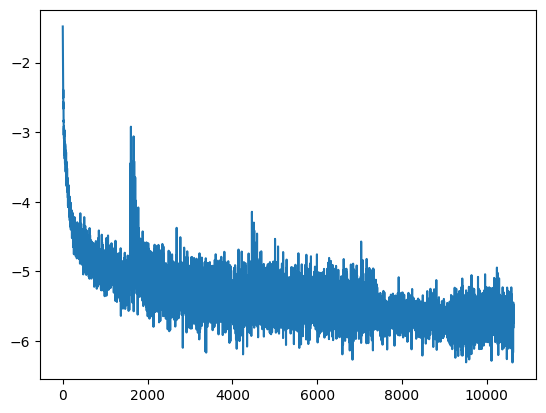

In [8]:
# Plot the loss
plt.plot(np.log(loss_hist))
plt.show()

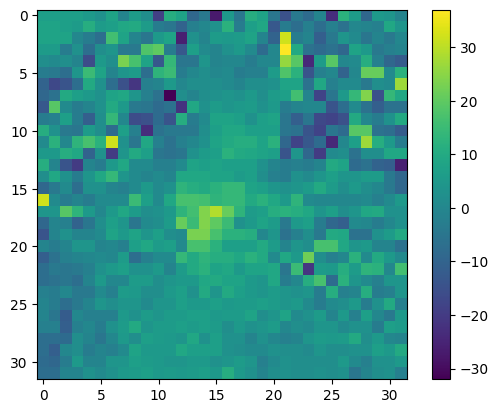

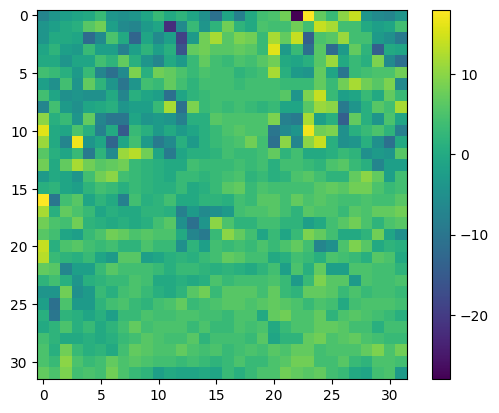

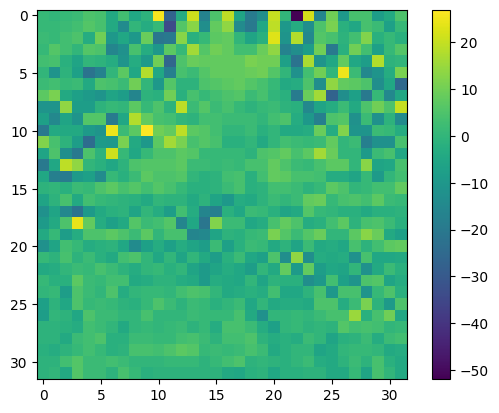

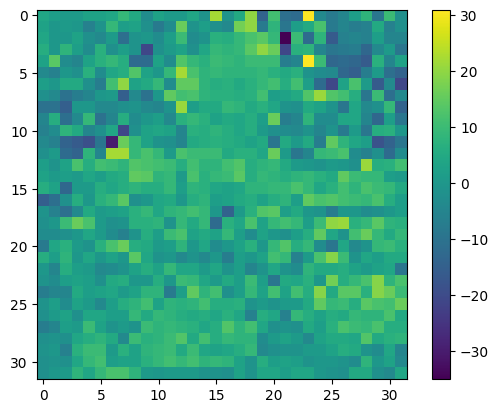

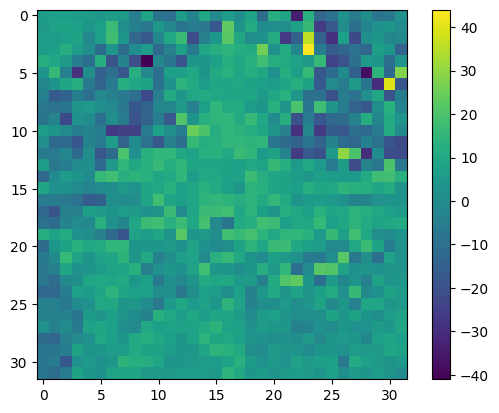

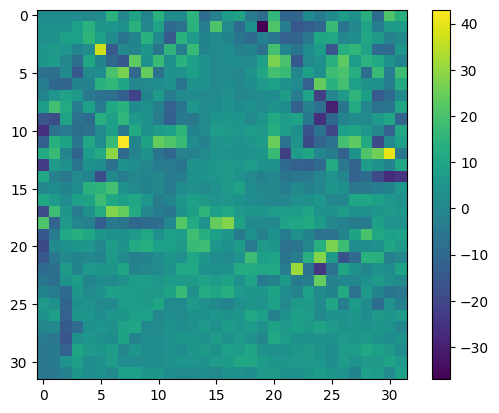

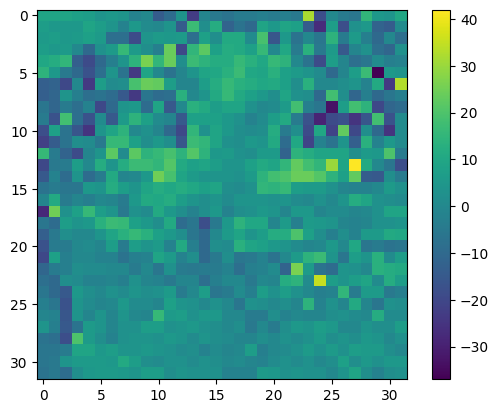

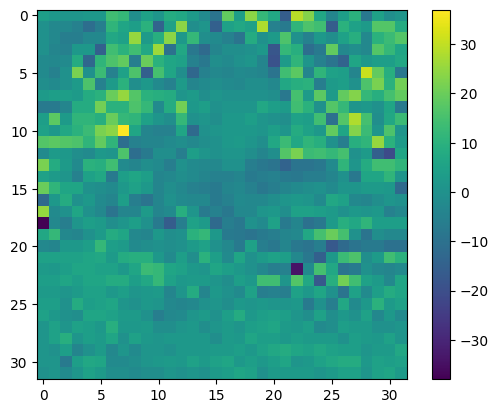

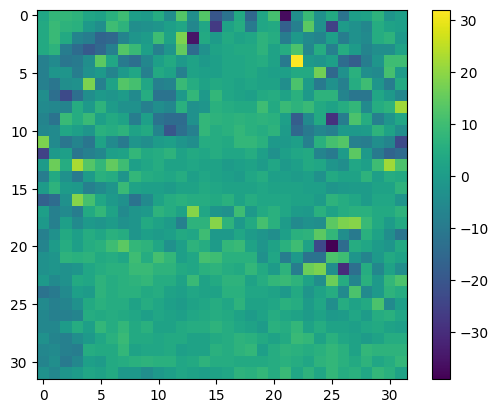

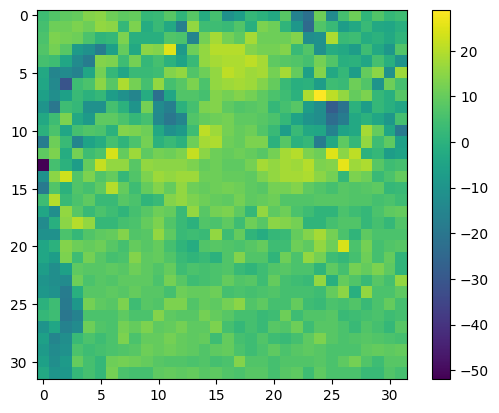

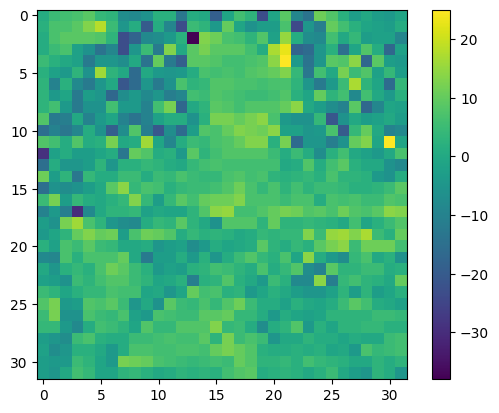

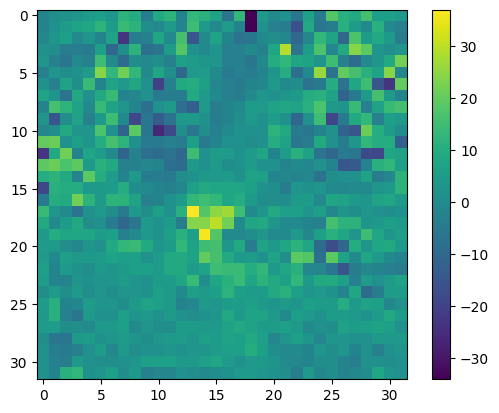

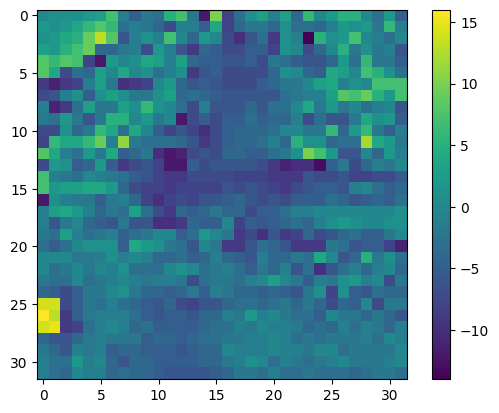

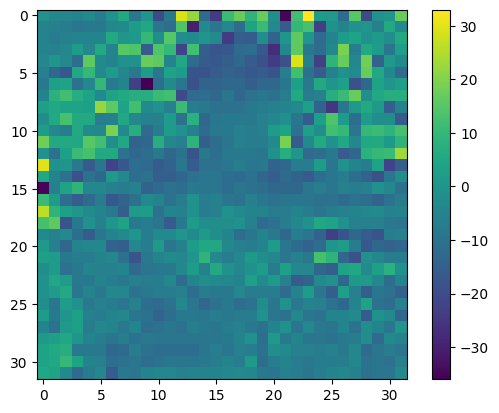

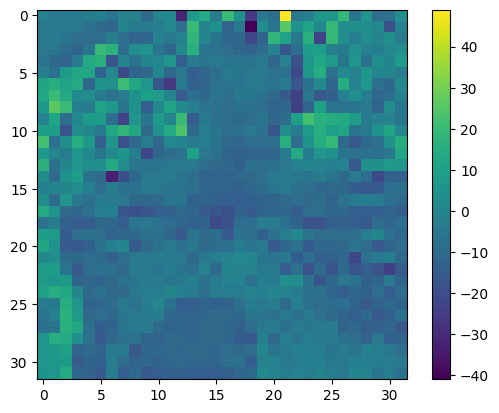

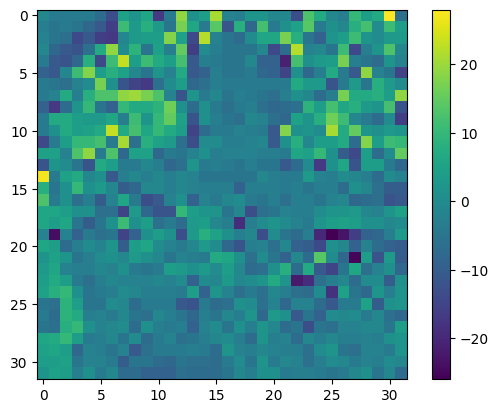

In [10]:
#plot the embeddings
embedding = tex_tf.numpy
#get quantized version
embedding = np.round(embedding*127.0)
embedding = np.clip(embedding, -127.0, 127.0)
for i in range(embedding.shape[2]):
    plt.imshow(embedding[:,:,i])
    plt.colorbar()
    plt.show()